## Load Packages

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter, ListedColormap
import seaborn as sns
import calendar
import datetime
import matplotlib.dates as mdates

from textblob import TextBlob
import squarify

## Function Definitions

In [2]:
# Define function to clean text
def preprocess(ReviewText):

    ReviewText = ReviewText.str.replace("(<br/>)", "")

    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')

    ReviewText = ReviewText.str.replace('(&amp)', '')

    ReviewText = ReviewText.str.replace('(&gt)', '')

    ReviewText = ReviewText.str.replace('(&lt)', '')

    ReviewText = ReviewText.str.replace('(\xa0)', ' ')

    return ReviewText

## Load Data

In [3]:
post_df = pd.read_csv('discussions.csv')
comments_df = pd.read_csv('comments.csv')

In [4]:
# Add title information to post content
post_df['content'] = post_df['content'].str.cat(post_df['title'], sep =". ", join = 'inner', na_rep = '')

In [5]:
# Modify timeformat of post data
post_df['postDate'] = pd.to_datetime(post_df['postDate'], format='%d/%m/%Y %H:%M')

# Create combined dataframe
combined_df = pd.concat([comments_df,post_df], ignore_index=True, join='inner')

In [6]:
post_df['content'] = preprocess(post_df['content'])
combined_df['content'] = preprocess(combined_df['content'])
combined_df['content'] = combined_df['content'].apply(str)

post_df['polarity'] = post_df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
combined_df['polarity'] = combined_df['content'].map(lambda text: TextBlob(text).sentiment.polarity)

post_df['post_len'] = post_df['content'].astype(str).apply(len)

post_df['word_count'] = post_df['content'].apply(lambda x: len(str(x).split()))

## Exploratory Data Analysis

In [7]:
# Summary Information

# The total number of posts in this competition
print("The total number of posts related to the ASHRAE Competition:",len(post_df))

# The total number of comments in this competition
print("The total number of comments related to the ASHRAE Competition:",len(comments_df))

# The number of competitors who participated in the discussion forum (either posting or commenting)
print("The number of competitors who participated in the ASHRAE Competition discussion forums:",len(np.unique(combined_df['author'])))

The total number of posts related to the ASHRAE Competition: 293
The total number of comments related to the ASHRAE Competition: 2508
The number of competitors who participated in the ASHRAE Competition discussion forums: 713


In [8]:
# Rank discussions by upvotes
print(post_df.sort_values(by = ['votes'], ascending=False)[['title','votes']])

                                              title  votes
0                 Energy prediction - small summary    220
13                                   Year-long path    108
15   Sites, buildings identified by internet search    107
11                                Findings from EDA    104
12                                       LB probing     98
..                                              ...    ...
290                    Need 3rd decimal of LB score     -2
291                orderliness in discussion forums     -3
258                                      Strike ???     -6
277       private lb now uses 11% of the test data?     -8
262                               Not Fair at all !    -20

[293 rows x 2 columns]


## Sentiment Analysis

In [9]:
print('5 posts with the highest sentiment polarity: \n')
cl = post_df.loc[post_df.polarity > 0.4, ['content']].sample(5).values
for c in cl:
    print(c[0])

5 posts with the highest sentiment polarity: 

Thanks for the great kagglers' sharing. I tried many kinds of feature engineering and model ensemble methods but it seems a gap still exists between the top and mine.
EDA is EVERYTHING.
I will post my linear regression model later. The idea is from @abednadir 's great r code.. Should have realized this is an ANOMALY DETECTION PROBLEM
While all of us are waiting patiently for Pvt. LB update after Christmas, I wanted to wish all of the teams and the competition organizers very happy holidays. Wishing for many more exciting competitions in 2020. 😃 😊 . Happy Holidays everyone
Hello fellow Kagglers:
NOTE: Posted on behalf of contest co-organizer Dr. Jeff Haberl, Texas A&M. 
Please find below a collection of technical papers that were generated as part of the ASHRAE Great Predictor Shootout I and II data competitions. 
While software stacks, technology and hardware availability have advanced significantly since this time period, the fundamentals

In [10]:
print('5 posts/comments with the highest sentiment polarity: \n')
cl = post_df.loc[post_df.polarity > 0.5 , ['content']].sample(5).values
for c in cl:
    print(c[0])

5 posts/comments with the highest sentiment polarity: 

Moving along with the competition, just need to know the views which is the best way to tackle the dataset and proceed with modelling!!. is the Best way time series or regression?
I have a bittersweet feeling, the last weeks I couldnt able to spend time on competition but the work is done and again i learnd a lot … 
thank all of you!!!  and Good Luck to everybody!!!. Last submit done, good luck to everybody
It seems like an inferno here…
More decimal digits would help a lot, but for the rest , I would not discuss…
Good luck everybody, may the force be with you, anyway !. Two months, Two digits decimals, 2 submissions a day...
Hi, everyone! So, how are you guys working with lag features? are you using it at all? I tried some with the weather and then with the building but i didn't get a good result… I'm using a LGBM model and currently my best score was without then.. Lag Features
While all of us are waiting patiently for Pvt. LB u

In [11]:
print('2 posts with the most negative polarity: \n')
cl = post_df.loc[post_df.polarity < -0.4, ['content']].sample(2).values
for c in cl:
    print(c[0])

2 posts with the most negative polarity: 

When I just faced zeroes in target variable, I just thought the meter_reader(?) went wrong. So I just thought I could predict target variable's 'zeroes' with ML. Is this a stupid idea?. How do you think predicting zeroes in target variable?
. Sorry, is this a web scraping competition?


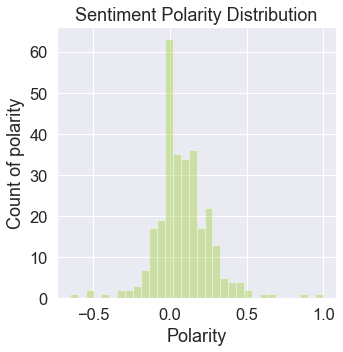

In [12]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(5,5))
ax = sns.distplot(post_df['polarity'], kde=False, color= "yellowgreen")
ax.title.set_text("Sentiment Polarity Distribution")
ax.set(ylabel="Count of polarity", xlabel="Polarity")
fig = ax.get_figure()
fig.savefig("graph/Sentiment Polarity Distribution.pdf", bbox_inches='tight')

In [13]:
# Remove comments with no content (e.g. picture/meme comments)
combined_df = combined_df[~combined_df['content'].isnull()]

### Create Treemap of Discussion Topics

In [14]:
# Create dataframe with counts of the discussion post 'tags'
topic_counts = post_df['tag'].value_counts()
topic_counts = topic_counts.to_frame()

# Assign column names
topic_counts.columns = ['Count']

print(topic_counts)

                               Count
Question                          43
Data Leak                         28
Feature Selection/Extraction      22
Other                             21
Preprocessing                     19
Modelling Strategy                18
Memory & Optimisation             17
Reference Material                16
Data Quality                      13
EDA                               13
Competition Feedback              11
Error Metric + Postprocessing     11
Kaggle + Technical Committee      11
Solution                          10
Rules and Enforcement              9
Site Locations                     8
LB Probing                         6
Team Formation                     6
Cross-validation                   6
Weather                            5


In [15]:
# Add \n to long label names
#as_list = topic_counts.index.tolist()
#idx = as_list.index('Error Metric + Postprocessing')
#as_list[idx] = 'Error Metric + \nPostprocessing'
#topic_counts.index = as_list

topic_counts.rename(index={'Error Metric + Postprocessing':'Error Metric +\nPostprocessing','Rules and Enforcement':
                          'Rules &\nEnforcement','Kaggle + Technical Committee':'Kaggle +\nTechnical Committee',
                          'Competition Feedback':'Competition\nFeedback','Memory & Optimisation':'Memory &\nOptimisation',
                          'Modelling Strategy':'Modelling \nStrategy','Reference Material':'Reference \nMaterial',
                          'Feature Selection/Extraction':'Feature \nSelection/Extraction','Team Formation':'Team \nFormation',
                          'Cross-validation':'Cross-\nValidation','Site Locations':'Site \nLocations'},inplace=True)

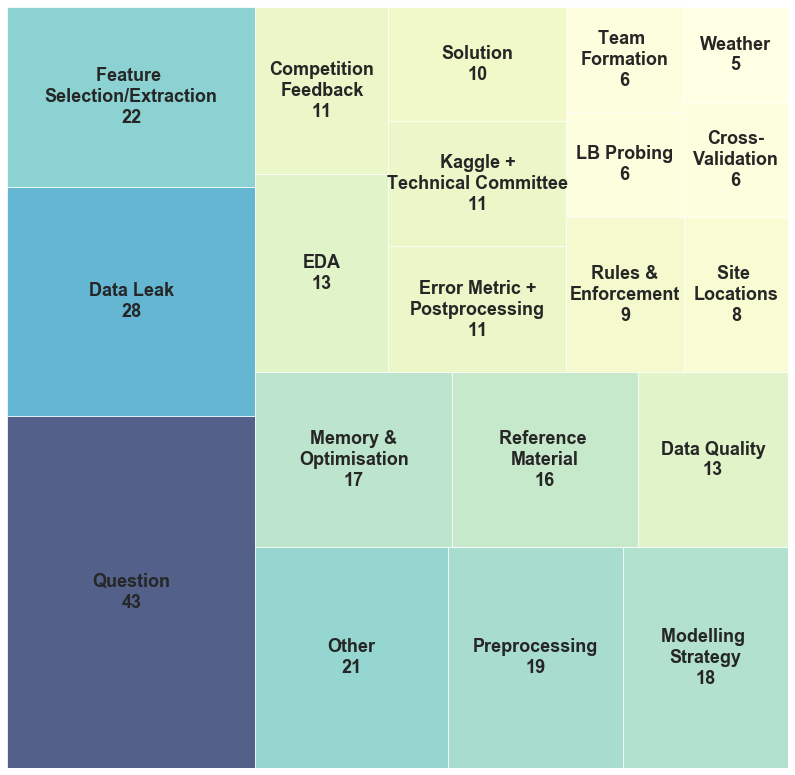

In [16]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 14)

norm = matplotlib.colors.Normalize(vmin=min(topic_counts['Count']), vmax=max(topic_counts['Count']))
colors = [matplotlib.cm.YlGnBu(norm(value)) for value in topic_counts['Count']]

squarify.plot(sizes=topic_counts['Count'],
                  label=topic_counts.index + '\n' + topic_counts['Count'].astype(str),
                  alpha=.7,
                  color = colors,
                  text_kwargs={'fontsize':18, 'weight':'bold'})
plt.axis('off')
#plt.title('Discussion Post Tag Count')
plt.savefig('graph/Discussion Tag Treemap.pdf', bbox_inches='tight')
plt.show()